In [1]:
#imports
import pandas as pd
import numpy as np
from datetime import datetime
from statistics import mode
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from scipy import stats

In [2]:
import time
import warnings
warnings.filterwarnings("ignore")

In [3]:
#load data
df = pd.read_csv("booking_train_set.csv")

In [4]:
df.head()

,Unnamed: 0,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id
0,0,1006220,2016-04-09,2016-04-11,31114,desktop,384,Gondal,Gondal,1006220_1
1,1,1006220,2016-04-11,2016-04-12,39641,desktop,384,Gondal,Gondal,1006220_1
2,2,1006220,2016-04-12,2016-04-16,20232,desktop,384,Gondal,Glubbdubdrib,1006220_1
3,3,1006220,2016-04-16,2016-04-17,24144,desktop,384,Gondal,Gondal,1006220_1
4,4,1010293,2016-07-09,2016-07-10,5325,mobile,359,The Devilfire Empire,Cobra Island,1010293_1


In [5]:
#first columns is a loading mistake, second is irrelevant: we are evaluating trip's tendancies not user's
df.drop(['Unnamed: 0', "user_id"], axis=1, inplace=True)

In [6]:
#Build dict city id to country:
city_to_country = {}
lst_cities = df.groupby("city_id").last().index
lst_associated_countries = df.groupby("city_id").last().hotel_country.values
for i in range(len(lst_cities)):
    city_to_country[lst_cities[i]] = lst_associated_countries[i]

with open("city_to_country.pkl", "wb") as f:
    pickle.dump(city_to_country, f)

In [7]:
print(f"Number of reservations: {df.shape[0]}")

Number of reservations: 1166835


In [8]:
trips = df.groupby("utrip_id").city_id.apply(np.array)

In [9]:
lens = [len(trip) for trip in trips]

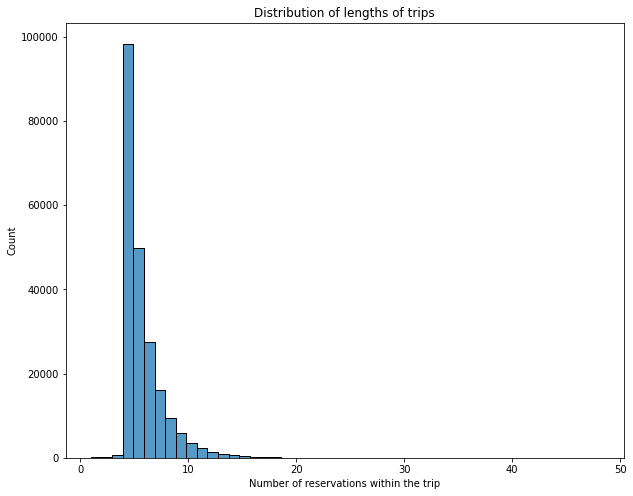

Most frequent size of a trip: 4
Median size of a trip: 5.0
Maximum size of a trip: 48
Number of trips with size 1: 113


In [10]:
import seaborn as sns
plt.figure(figsize=(10,8))

sns.histplot(lens, bins=48)
plt.title("Distribution of lengths of trips")
plt.xlabel("Number of reservations within the trip")
plt.show()

print(f"Most frequent size of a trip: {stats.mode(lens)[0][0]}")
print(f"Median size of a trip: {np.median(lens)}")
print(f"Maximum size of a trip: {np.max(lens)}")
print(f"Number of trips with size 1: {(np.array(lens) == 1).sum()}")

In [11]:
print(f"Number of different cities: {df.city_id.nunique()}")
print(f"Number of different countries: {df.hotel_country.nunique()}")
print(f"Number of trips: {df.utrip_id.nunique()}")

Number of different cities: 39901
Number of different countries: 195
Number of trips: 217686


In [12]:
#let's count city_id
countries_df = pd.DataFrame(df.groupby("hotel_country").city_id.count())
countries_df["unique_city_id"] = df.groupby("hotel_country").city_id.nunique()
most_represented_countries = countries_df.sort_values("city_id").city_id[-20:]

In [13]:
print(f"Median number of reservation in each country: {countries_df.city_id.median()}")
print(f"{(countries_df.city_id < 10).sum()} countries have less than 10 reservations")

Median number of reservation in each country: 199.0
40 countries have less than 10 reservations


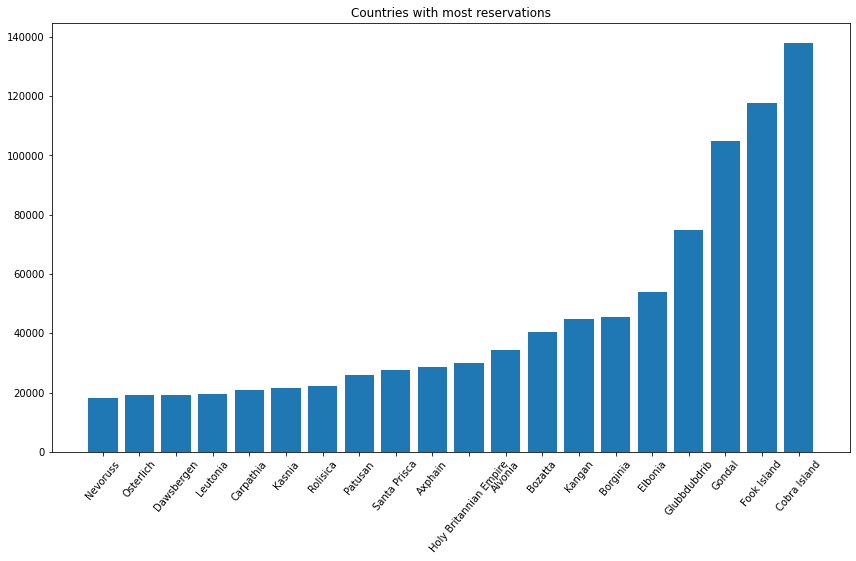

In [14]:
import seaborn as sns
plt.figure(figsize=(12,14))

plt.subplot(2,1,1)
plt.bar(most_represented_countries.index,most_represented_countries)
plt.title("Countries with most reservations")
plt.xticks(rotation=50)

plt.tight_layout()

plt.show()

In [15]:
vc = df.city_id.value_counts()

def choose_threshold(n):
    print(f"By choosing this threshold of {n}, you keep {vc.loc[vc.values > n].shape[0]} cities, \nwhich account for {np.round(vc.loc[vc.values > n].sum() / df.shape[0], 2)} reservations of the total")
    return vc.loc[vc.values > n].index

In [16]:
cities_index = choose_threshold(6)

By choosing this threshold of 6, you keep 12345 cities, 
which account for 0.95 reservations of the total


Let's choose 6, in order to keep 95% of reservation but divides number of cities by more than 3

In [17]:
filtered_df = df.loc[df.city_id.isin(cities_index)]

In [18]:
print(f"Number of different cities: {filtered_df.city_id.nunique()}")
print(f"Number of different countries: {filtered_df.hotel_country.nunique()}")
print(f"Number of trips: {filtered_df.utrip_id.nunique()}")

Number of different cities: 12345
Number of different countries: 148
Number of trips: 217411


### Problem: By doing so we suppressed about 50 countries, with small amounts of reservations. We  eventually decide to keep them.

In [19]:
df.head()

,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id
0,2016-04-09,2016-04-11,31114,desktop,384,Gondal,Gondal,1006220_1
1,2016-04-11,2016-04-12,39641,desktop,384,Gondal,Gondal,1006220_1
2,2016-04-12,2016-04-16,20232,desktop,384,Gondal,Glubbdubdrib,1006220_1
3,2016-04-16,2016-04-17,24144,desktop,384,Gondal,Gondal,1006220_1
4,2016-07-09,2016-07-10,5325,mobile,359,The Devilfire Empire,Cobra Island,1010293_1


In [20]:
#fit our encoders on all data
from sklearn.preprocessing import LabelEncoder
encode_cities = LabelEncoder()
encode_devices = LabelEncoder()
encode_affiliate_id = LabelEncoder()
encode_hotel_country = LabelEncoder()
encode_booker_country = LabelEncoder()

encode_cities.fit(df.city_id)
encode_devices.fit(df.device_class)
encode_affiliate_id.fit(df.affiliate_id)
encode_hotel_country.fit(df.hotel_country)
encode_booker_country.fit(df.booker_country)

#Save those encoders for preprocessing test data

with open("Preprocessing_encoders.pkl", "wb") as f:
    pickle.dump([encode_cities, encode_devices, encode_affiliate_id, 
                 encode_hotel_country, encode_booker_country], f)

___________

## Saving a test dataframe

In [21]:
df.head()

,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id
0,2016-04-09,2016-04-11,31114,desktop,384,Gondal,Gondal,1006220_1
1,2016-04-11,2016-04-12,39641,desktop,384,Gondal,Gondal,1006220_1
2,2016-04-12,2016-04-16,20232,desktop,384,Gondal,Glubbdubdrib,1006220_1
3,2016-04-16,2016-04-17,24144,desktop,384,Gondal,Gondal,1006220_1
4,2016-07-09,2016-07-10,5325,mobile,359,The Devilfire Empire,Cobra Island,1010293_1


In [22]:
import random
random.seed(42)
print(f"There is {df.utrip_id.nunique()} different trips")
n_samples = int(np.round(df.utrip_id.nunique() * 0.05))
print(f'We will use 5% in our test set: {n_samples}')


test_index = random.sample(list(df.utrip_id.unique()), n_samples)

There is 217686 different trips
We will use 5% in our test set: 10884


In [23]:
#Split between test and train data
test_set = df.loc[df.utrip_id.isin(test_index)]
train_set = df.loc[np.invert(df.utrip_id.isin(test_index))]

In [24]:
print(f"We kept {train_set.city_id.nunique()} different cities in our train set")

We kept 39296 different cities in our train set


In [25]:
#reset index
test_set.reset_index(drop=True, inplace=True)

In [26]:
## Let's hide targets of test set
test_set["is_new_trip"] = test_set[["utrip_id"]].shift() != test_set[["utrip_id"]]

#Start of the trips - 1
end_of_trips = np.array(test_set.loc[test_set.is_new_trip].index) - 1
#We remove first element
end_of_trips = end_of_trips[1:]
#And add the last one
end_of_trips = np.append(end_of_trips, test_set.index[-1])

test_set["is_target"] = test_set.index.isin(end_of_trips)

In [27]:
#Save targets
y_test = test_set.loc[test_set.is_target][["utrip_id", "hotel_country", "city_id"]]
y_test

,utrip_id,hotel_country,city_id
3,1174942_1,Santa Prisca,12308
8,1311136_1,Kangan,4202
12,1335169_1,Cobra Island,63977
16,133917_7,Gondal,6104
24,1450445_1,Glubbdubdrib,51291
...,...,...,...
58624,740769_1,Lilliput,46794
58629,895103_1,Bozatta,9161
58633,959109_1,Glubbdubdrib,19254
58645,965262_1,Osterlich,47759


In [28]:
#hide hotel country and city_id in test set df
test_set.loc[test_set.is_target,'hotel_country']= "?"
test_set.loc[test_set.is_target,'city_id']= "?"

In [29]:
test_set.head()

,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,is_new_trip,is_target
0,2016-06-01,2016-06-03,20764,tablet,9452,Gondal,Santa Prisca,1174942_1,True,False
1,2016-06-03,2016-06-04,59001,tablet,9452,Gondal,Santa Prisca,1174942_1,False,False
2,2016-06-04,2016-06-07,15186,tablet,9452,Gondal,Santa Prisca,1174942_1,False,False
3,2016-06-07,2016-06-10,?,desktop,384,Gondal,?,1174942_1,False,True
4,2016-05-11,2016-05-13,60237,desktop,5755,Gondal,Kangan,1311136_1,True,False


In [30]:
#Save test set for later
with open("test_data.pkl", "wb") as f:
    pickle.dump([test_set, y_test], f)

## Working on Train/Val data

In [31]:
df = train_set

In [32]:
df.head(3)

,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id
0,2016-04-09,2016-04-11,31114,desktop,384,Gondal,Gondal,1006220_1
1,2016-04-11,2016-04-12,39641,desktop,384,Gondal,Gondal,1006220_1
2,2016-04-12,2016-04-16,20232,desktop,384,Gondal,Glubbdubdrib,1006220_1


Let's apply some preprocessing

In [33]:
#Transform dates into datetime format
df.checkin = df.checkin.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df.checkout = df.checkout.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

In [34]:
#New column: how much days spent in the hotel
df["days_in_hotel"] = df[["checkin", "checkout"]].apply(lambda x: (x[1] - x[0]).days, axis=1)

In [35]:
#Min and max dates
df.checkin.min(), df.checkout.max()

(Timestamp('2015-12-31 00:00:00'), Timestamp('2017-02-28 00:00:00'))

Everything takes place between those dates, we will add season shift dates

In [36]:
#define seasons key dates
winter_start = datetime.strptime("2015-12-21", "%Y-%m-%d")
spring_start = datetime.strptime("2016-03-20", "%Y-%m-%d")
summer_start = datetime.strptime("2016-06-20", "%Y-%m-%d")
autumn_start = datetime.strptime("2016-09-22", "%Y-%m-%d")
winter_start2 = datetime.strptime("2016-12-21", "%Y-%m-%d")

In [37]:
def get_season(date):
    if date < spring_start:
        # 0 for winter
        return 0
    if date < summer_start:
        # 1 for spring
        return 1
    if date < autumn_start:
        # 2 for summer
        return 2
    if date < winter_start2:
        # 3 for autumn
        return 3
    #else: it is the start of 2017, hence winter
    return 0

In [39]:
#get current season when checking in or checking out
df["checkin_season"] = df.checkin.apply(get_season)
df["checkout_season"] = df.checkout.apply(get_season)

In [40]:
df["month_reservation"] = df.checkin.apply(lambda x: x.month)

Let's inspect consecutive cities

In [42]:
#Let's deal with trip with consecutive cities
df["is_new_trip"] = df[["utrip_id"]].shift() != df[["utrip_id"]]
df["is_new_city"] = df[["city_id"]].shift() != df[["city_id"]]

In [43]:
#When it is both not a new trip, and not a new city, it means it is a consecutive city reservation within a trip
df["is_consecutive_res"] = (df.is_new_city == False) & (df.is_new_trip == False)

In [44]:
print(f"{np.round(df.is_consecutive_res.sum() / df.shape[0], 2)} of reservations are made in the same city as before")

0.07 of reservations are made in the same city as before


In [45]:
consec = df.loc[df.is_consecutive_res].city_id.value_counts().to_dict()
total_count = df.city_id.value_counts().to_dict()

In [46]:
for city in consec.keys():
    consec[city] = consec[city] / total_count[city]

In [47]:
with open("consecutive_cities.pkl", "wb") as f:
    pickle.dump(consec, f)

We decide to remove them

In [48]:
#remove consecutive reservations
filtered_df = df.loc[np.invert(df.is_consecutive_res)]

In [50]:
col_to_drop = ["checkin","checkout", "checkout_season", "is_consecutive_res", 
                "is_new_city", "is_new_trip"]

filtered_df.drop(col_to_drop, axis=1, inplace=True)

Now, we need to encode most of our data

In [51]:
filtered_df.city_id = encode_cities.transform(filtered_df.city_id)
filtered_df.device_class = encode_devices.transform(filtered_df.device_class)
filtered_df.affiliate_id = encode_affiliate_id.transform(filtered_df.affiliate_id)
filtered_df.hotel_country = encode_hotel_country.transform(filtered_df.hotel_country)
filtered_df.booker_country = encode_booker_country.transform(filtered_df.booker_country)

In [52]:
filtered_df.head()

,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,days_in_hotel,checkin_season,month_reservation
0,18386,0,134,2,60,1006220_1,2,1,4
1,23415,0,134,2,60,1006220_1,1,1,4
2,11933,0,134,2,59,1006220_1,4,1,4
3,14304,0,134,2,60,1006220_1,1,1,4
4,3164,1,125,4,36,1010293_1,1,2,7


In [53]:
#Save the preprocessed df
with open("preprocessed_df.pkl", "wb") as f:
    pickle.dump(filtered_df, f)

_____

______________